# Topic extraction

Using `tomotopy`'s LDA implementation.
Comparing different token weighings — nominal, IDF, and PMI (Pointwise Mutual Information) in terms of topic coherence.

In [18]:
%load_ext autotime

import psycopg2
import numpy
from time import time
import nltk
import wordcloud
import matplotlib.pyplot as plt
import gensim

# DATASET_NAME = 'small'
# N_REPEATS = 2
# N_ITERATIONS = 1000
# N_TOPICS = 3

DATASET_NAME = '200k-lemma-nophrase'
N_REPEATS = 50
N_ITERATIONS = 1000
N_TOPICS = 35

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.4 ms


In [19]:
def log(message):
    print(message, flush=True)

time: 669 µs


In [20]:
import pickle

log('Loading dataset...')
dataset = pickle.load(open(f'dataset.{DATASET_NAME}.pkl', 'rb'))
data_train = dataset['train']
data_test  = dataset['test']

print("Building gensim corpus...")
gensim_dictionary = gensim.corpora.Dictionary(data_train)

log(f'{len(data_train)} training documents')
log(f'{len(data_test)} test documents')

Loading dataset...
Building gensim corpus...
145953 training documents
36489 test documents
time: 6.84 s


In [21]:
import tomotopy as tp
from tqdm import tqdm
corpus_train = tp.utils.Corpus()

for doc in tqdm(data_train):
    corpus_train.add_doc(doc)

100%|██████████| 145953/145953 [00:01<00:00, 73481.52it/s] 

time: 2.16 s


In [22]:
def prepare_model(k, tw, corpus):
    model = tp.LDAModel(tw=tw, k=k, corpus=corpus)
    return model

time: 496 µs


In [6]:
import helpers as h

models = []
train_perplexity = {}
test_perplexity = {}
coherence_c_v = {}
coherence_u_mass = {}
coherence_c_npmi = {}
iterations = {}
training_time = {}

log('Preparing models...')
for tw in tqdm([tp.TermWeight.ONE, tp.TermWeight.IDF, tp.TermWeight.PMI] * N_REPEATS):
    models.append(prepare_model(k=N_TOPICS, tw=tw, corpus=corpus_train))

log('Training models...')
for i,m in tqdm(enumerate(models)):
    t,n = h.train_model(m)
    iterations[i] = n
    training_time[i] = t

Preparing models...


100%|██████████| 60/60 [00:45<00:00,  1.32it/s]

Training models...



60it [1:38:48, 98.81s/it] 

time: 1h 39min 34s


In [7]:
log('Calculating perplexity...')
for i, model in tqdm(enumerate(models)):
    train_perplexity[i] = h.eval_perplexity(model, data_train)
    test_perplexity[i]  = h.eval_perplexity(model, data_test)

Calculating perplexity...


60it [07:28,  7.48s/it]

time: 7min 28s


In [8]:
log('Calculating C_v coherence...')
for i, model in tqdm(enumerate(models)):
    cv = h.eval_coherence(h.get_topic_words(model), gensim_dictionary, data_train, coherence_type='c_v')
    coherence_c_v[i] = cv

Calculating C_v coherence...


60it [11:36, 11.60s/it]

time: 11min 36s


In [9]:
log('Calculating U_mass coherence...')
for i, model in tqdm(enumerate(models)):
    cu = h.eval_coherence(h.get_topic_words(model), gensim_dictionary, data_train, coherence_type='u_mass')    
    coherence_u_mass[i] = cu

Calculating U_mass coherence...


60it [06:13,  6.23s/it]

time: 6min 13s


In [10]:
log('Calculating C_npmi coherence...')
coherence_c_npmi = {}
for i, model in tqdm(enumerate(models)):
    cu = h.eval_coherence(h.get_topic_words(model), gensim_dictionary, data_train, coherence_type='c_npmi')    
    coherence_c_npmi[i] = cu

Calculating C_npmi coherence...


60it [10:24, 10.41s/it]

time: 10min 24s


In [11]:
import collections
import numpy as np

# returns x, avg, stddev
def prep_metric(data, models):
    d = collections.defaultdict(list)
    for i, v in data.items():
        k = models[i].tw
        d[k].append(v)
    x = []
    y = []
    s = []
    for k, l in d.items():
        a = np.array(l)
        x.append(k)
        y.append(np.median(a))
        s.append(np.std(a))
    
    return (x,y,s)

time: 1.27 ms


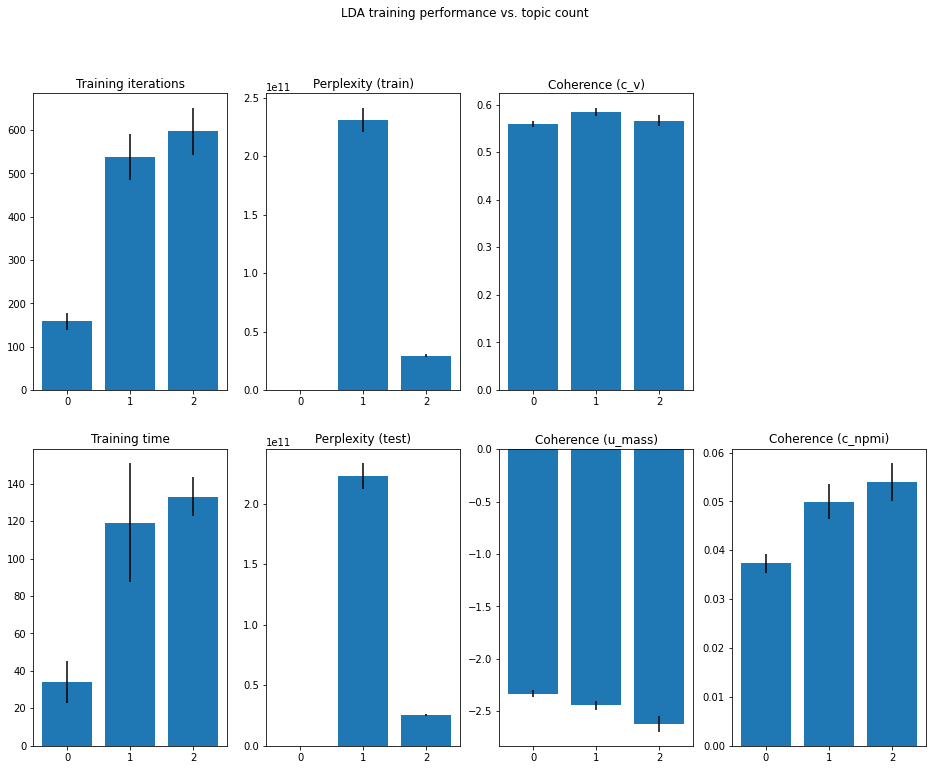

time: 568 ms


In [17]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('LDA training performance vs. topic count')


x,y,s = prep_metric(iterations, models)

plt.subplot(241)
plt.bar(x,y,yerr=s)
plt.title('Training iterations')


x,y,s = prep_metric(training_time, models)

plt.subplot(245)
plt.bar(x,y,yerr=s)
plt.title('Training time')


x,y,s = prep_metric(train_perplexity, models)

plt.subplot(242)
plt.bar(x,y,yerr=s)
plt.title('Perplexity (train)')


x,y,s = prep_metric(test_perplexity, models)

plt.subplot(246)
plt.bar(x,y,yerr=s)
plt.title('Perplexity (test)')


x,y,s = prep_metric(coherence_c_v, models)
plt.subplot(243)
plt.bar(x,y,yerr=s)
plt.title('Coherence (c_v)')


x,y,s = prep_metric(coherence_u_mass, models)

plt.subplot(247)
plt.bar(x,y,yerr=s)
plt.title('Coherence (u_mass)')


x,y,s = prep_metric(coherence_c_npmi, models)

plt.subplot(248)
plt.bar(x,y,yerr=s)
plt.title('Coherence (c_npmi)')

plt.show()



In [13]:
import datetime
print(datetime.datetime.now().strftime('%F %T'))

2020-06-17 11:05:24
time: 524 µs


In [14]:
# dir(corpus_train)
docs = [models[1].make_doc(d) for d in data_train]
_,lls=models[1].infer(doc=docs)
lengths = [len(d) for d in data_train]

np.sum(np.asarray(lls)) / np.sum(lengths)

-26.291759376832815

time: 8.03 s


In [15]:
h.eval_perplexity(models[2], data_train)

32122797156.264767

time: 6.94 s
